# Rethinking Statistics course in Stan - Week 3

Lecture 5: Spurious Waffles

- [Video](https://www.youtube.com/watch?v=e0tO64mtYMU&index=5&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI)
- [Slides](https://speakerdeck.com/rmcelreath/l05-statistical-rethinking-winter-2019)

Lecture 6: Haunted DAG

- [Video](https://youtu.be/l_7yIUqWBmE)
- [Slides](https://speakerdeck.com/rmcelreath/l06-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week03.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week03_solutions.pdf) for the exercises of the week.

In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
from plotnine import *

In [2]:
%load_ext watermark
%watermark -n -u -p pandas,numpy,cmdstanpy,plotnine

Last updated: Fri Dec 31 2021

pandas   : 1.3.4
numpy    : 1.21.4
cmdstanpy: 1.0.0
plotnine : 0.8.0



All three problems below are based on the same data. The data in data `foxes` are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. `groupsize` varies from 2 to 8 individuals. Each group maintains its own, almost exclusive, urban territory. Some territories are larger than others. The `area` variable encodes this information. Some territories also have more `avgfood` than others. We want to model the `weight` of each fox. For the problems below, assume this DAG:

<img src="./fig/w1_img1.png" width="60%">

Let's get the data.

In [3]:
d = pd.read_csv('./dat/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


## Exercise 1

> Use a model to infer the total causal influence of `area` on `weight`. Would increasing the `area` available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model's prior predictions stay within the possible outcome range.

Standarise the data first of all:

In [4]:
cols = ['avgfood','groupsize','area','weight']
d[cols] = (d[cols]-d[cols].mean())/d[cols].std()

Because there are no back-door paths from `area` to `weight`, we only need to include `area`. No other variables are needed. Here is a model using standardized versions of the variables and those standardized priors from the book. Also, a generic regression model is used where the variables `x`and `y` are renamed in each exercise.

In [5]:
model = '''

data {
    int n;
    vector[n] x;
    vector[n] y;
}

parameters {
    real alpha;
    real beta;
    real sigma;
}

model {
    // priors
    alpha ~ normal(0, 0.2);
    beta ~ normal(0, 0.5);
    sigma ~ uniform(0, 2);
    // likelihood
    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {
    vector[n] y_ppc;
    for (i in 1:n) {y_ppc[i] = normal_rng(alpha + beta * x[i], sigma);}
}

'''

stan_file = './stn/week03.stan'
with open('./stn/week03.stan', 'w') as f:
    print(model, file=f)

stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week03.stan to exe file /home/jovyan/work/statret/stn/week03
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week03
INFO:cmdstanpy:found newer exe file, not recompiling


In [6]:
%%time
data = d[['area', 'weight']].rename(columns={'area':'x', 'weight':'y'})
data = data.to_dict(orient='list')
data['n'] = len(data['x'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 236 ms, sys: 109 ms, total: 344 ms
Wall time: 450 ms


In [7]:
stan_fit.summary().loc[['alpha', 'beta', 'sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,0.00011,0.0013,0.085,-0.14,-0.00047,0.14,4200.0,8800.0,1.0
beta,0.01800,0.0015,0.095,-0.14,0.01900,0.18,3900.0,8200.0,1.0
sigma,1.00000,0.0011,0.067,0.91,1.00000,1.10,4000.0,8400.0,1.0


Territory size (`area`) seems to have no total causal influence on `weight`, at least not in this sample. We can also plot the posterior using `plotnine` in a nice way.

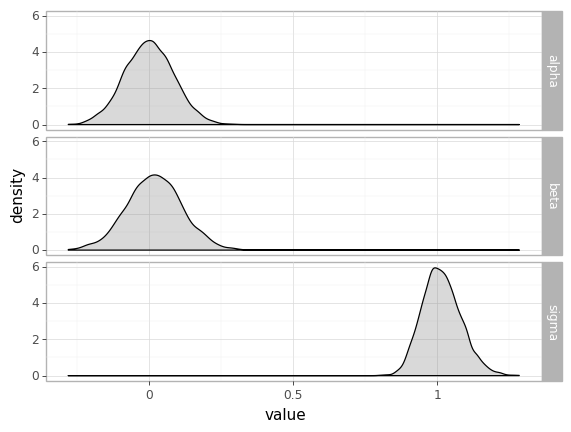

<ggplot: (8737960591342)>

In [8]:
atts = ['alpha', 'beta', 'sigma']
df = stan_fit.draws_pd(vars=atts)
im = pd.melt(df, value_vars=atts)

(
    ggplot(im)
    + aes(x='value')
    + geom_density(fill='grey', alpha=0.3)
    + theme_light()
    + facet_grid('variable ~ .')
)

Let's visualize the data to see if exists a relationship between `area` and `weight` that is logical and possible. It does not seem that.

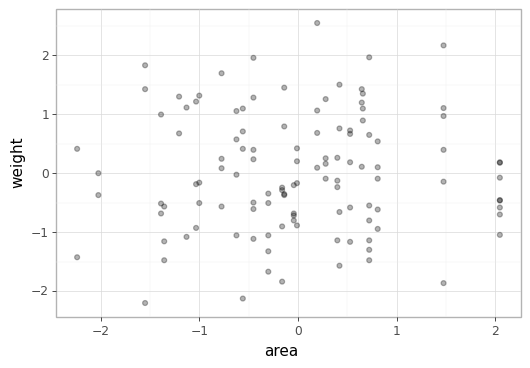

<ggplot: (8737960154874)>

In [9]:
im = d[['area', 'weight']].copy()

(
    ggplot(im)
    + aes(x='area', y='weight')
    + geom_point(alpha=0.3)
    + theme_light()
    + theme(figure_size=(6,4))
)

## Exercise 2

> Now infer the causal impact of adding food (`avgfood`) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

To infer the causal influence of `avgfood` on `weight`, we need to close any back-door paths. There are no back-door paths in the DAG. So again, just use a model with a single predictor. If you include `groupsize`, to block the indirect path, then you won't get the total causal influence of food. You'll just get the direct influence. But I asked for the effect of adding food, and that would mean through all forward paths.

In [10]:
%%time
data = d[['avgfood', 'weight']].rename(columns={'avgfood':'x', 'weight':'y'})
data = data.to_dict(orient='list')
data['n'] = len(data['x'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 312 ms, sys: 165 ms, total: 477 ms
Wall time: 509 ms


In [11]:
stan_fit.summary().loc[['alpha', 'beta', 'sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,-0.000042,0.0014,0.086,-0.14,0.00025,0.14,3700.0,8400.0,1.0
beta,-0.023000,0.0016,0.095,-0.18,-0.02300,0.13,3700.0,8500.0,1.0
sigma,1.000000,0.0011,0.068,0.91,1.00000,1.10,3500.0,8100.0,1.0


Again nothing. Adding food does not change `weight`. It can be checked visualizing the relation between `avgfood` and `weight`. This shouldn't surprise you, if the DAG is correct, because `area` is upstream of `avgfood`.

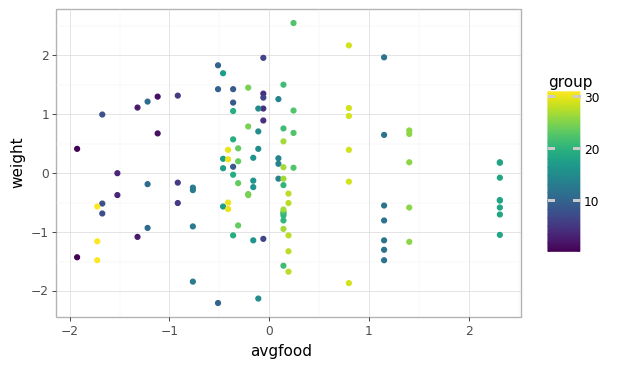

<ggplot: (8737960566179)>

In [12]:
im = d[['avgfood', 'weight', 'group']]

(
    ggplot(im)
    + aes(x='avgfood', y='weight', color='group')
    + geom_point()
    + theme_light()
    + theme(figure_size=(6,4))
)

## Exercise 3

> Now infer the causal impact of `groupsize`. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

In [13]:
%%time
data = d[['groupsize', 'weight']].rename(columns={'groupsize':'x', 'weight':'y'})
data = data.to_dict(orient='list')
data['n'] = len(data['x'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 264 ms, sys: 141 ms, total: 404 ms
Wall time: 426 ms


In [14]:
stan_fit.summary().loc[['alpha', 'beta', 'sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,0.0012,0.0014,0.084,-0.14,0.0012,0.140,3800.0,8800.0,1.0
beta,-0.1600,0.0015,0.092,-0.31,-0.1500,-0.006,3700.0,8700.0,1.0
sigma,1.0000,0.0012,0.067,0.90,1.0000,1.100,3400.0,7900.0,1.0


Very cool! This in an example of **collider** between two variables. The direct effect of `avgfood` is actually positive! But since it is controlled by the negative effect of `groupsize` the total effect of `avgfood` on `weight` is nothing. It looks like `groupsize` is negatively associated with `weight`, controlling for `avgfood`. Similarly, `avgfood` is positively associated with `weight`, controlling for `groupsize`. So the causal influence of `groupsize` is to reduce `weight` less food for each fox. And the direct causal influence of `avgfood` is positive, of course. But the total causal influence of `avgfood` is still nothing, since it causes
larger groups. This is a masking effect, like in the milk energy example. But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an ideal free distribution.

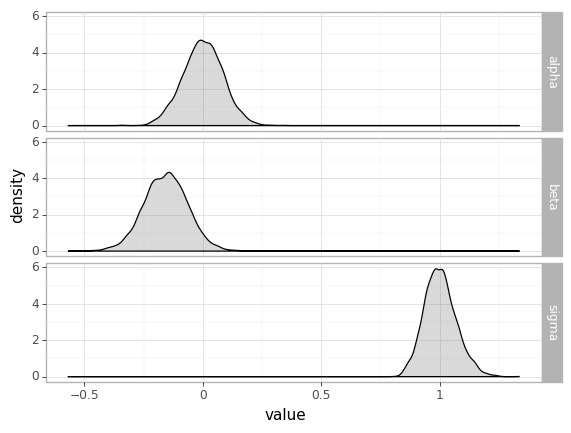

<ggplot: (8737961081296)>

In [15]:
atts = ['alpha', 'beta', 'sigma']
df = stan_fit.draws_pd(vars=atts)
im = pd.melt(df, value_vars=atts)

(
    ggplot(im)
    + aes(x='value')
    + geom_density(fill='grey', alpha=0.3)
    + theme_light()
    + facet_grid('variable ~ .')
)